### Imports

In [6]:
import datetime
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import sys
import random


from time import time
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

### Upload data

In [7]:
#Setting correct path 
cwd = os.getcwd() # Get current working directory
root_folder = os.sep + "ML-Neuron-Classification"
sys.path.insert(0, cwd[:(cwd.index(root_folder)+len(root_folder))] + os.sep)
from utils.helper_functions import*
from utils.unpacking_dat_files import*
from utils.autoencoder import*

nmi = normalized_mutual_info_score
ari = adjusted_rand_score
date = datetime.date.today()

#Upload data
data_path = 'C:/Users/Marius/Documents/Datasets/.txt/ec014.42_794_796_798_spikes.txt'
x = np.genfromtxt(data_path, usecols=list(range(0,256)), skip_header=1)
parameters = np.genfromtxt(data_path, dtype=None, encoding='UTF-8', usecols=list(range(256,267)), skip_header=1)

### Preprocessing

In [8]:
#Include paramter information into main array
classification = np.empty(shape=(x.shape[0],1))
for i in range(0, x.shape[0]):
  if parameters[i][8] != 0 and parameters[i][9] == 0: #excitatory
    classification[i] = 0
  elif parameters[i][8] == 0 and parameters[i][9] != 0: #inhibitory
    classification[i] = 1
  else:
    classification[i] = 2 #neither
  i=i+1
x = np.append(x, classification, axis=1)
x = x[x[:,256] != 2] #No neither

excits = x[x[:,256] == 0]
inhibs = x[x[:,256] == 1]

#rnd1 = np.random.choice(excits.shape[0], 10000, replace=False) #As more inhibs, choose randomly from inhibibitory to get same number of both types
rnd2 = np.random.choice(inhibs.shape[0], excits.shape[0], replace=False) #As more inhibs, choose randomly from inhibibitory to get same number of both types
#excits = excits[rnd1,:]
inhibs = inhibs[rnd2,:]
print("#Exciting traces:", excits.shape[0])
print("#Inhibiting traces:", inhibs.shape[0])
x = np.concatenate([excits, inhibs], axis=0) #back together
x = np.take(x,np.random.permutation(x.shape[0]),axis=0,out=x) #random shuffle
print("#Total traces:", x.shape[0])

Y_train = x[:,256]
X = x[:,:-1]

#X = isolate_maximum_electrode(X)
X_train = normalization_train(X)

#Reshape data
#X_train = X_train.reshape(X_train.shape[0], 8, 32)
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


print('Self-training with', X_train.shape[0], 'traces!')
n_clusters = len(np.unique(Y_train))
print(np.unique(Y_train))
print(n_clusters)

#Exciting traces: 13155
#Inhibiting traces: 13155
#Total traces: 26310
Self-training with 26310 traces!
[0. 1.]
2


### Hyperparameter

In [9]:
#Hyperparameters
dims = [X_train.shape[-1], 500, 500, 2000, 7]
#init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = 'Adam'#tf.keras.optimizers.Adam(learning_rate=0.001, decay=1.e-6)
pretrain_epochs = 900
batch_size = 128
save_dir = 'C:/Users/Marius/Documents/GitHub/ML-Neuron-Classification/Unsupervised learning/Model weights/Testing_variationalAutoencoder'
name_save_process = f'{date}_1_DEC_{pretrain_epochs}epochs_pretrain.h5'
name_save_final = f'{date}_1_DEC_{pretrain_epochs}epochs_final.h5'

### Pre-training

In [10]:
autoencoder, encoder = autoencoder(dims)
#autoencoder, encoder = autoencoder_LSTM(dims, X_train)
#autoencoder, encoder = autoencoder_LSTM_Marius(X_train, dims)
#autoencoder, encoder = autoencoder_LSTM_2D(dims, X_train)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir + name_save_process)

Train on 26310 samples
Epoch 1/900
26310/26310 [==============================] - 10s 380us/sample - loss: 1.7476e-04
Epoch 2/900
26310/26310 [==============================] - 10s 361us/sample - loss: 1.2196e-04
Epoch 3/900
26310/26310 [==============================] - 10s 381us/sample - loss: 1.1725e-04
Epoch 4/900
26310/26310 [==============================] - 11s 418us/sample - loss: 1.1539e-04
Epoch 5/900
26310/26310 [==============================] - 10s 387us/sample - loss: 1.1380e-04
Epoch 6/900
26310/26310 [==============================] - 10s 390us/sample - loss: 1.1278e-04
Epoch 7/900
26310/26310 [==============================] - 10s 384us/sample - loss: 1.1196e-04
Epoch 8/900
26310/26310 [==============================] - 10s 397us/sample - loss: 1.1126e-04
Epoch 9/900
26310/26310 [==============================] - 10s 397us/sample - loss: 1.1069e-04
Epoch 10/900
26310/26310 [==============================] - 10s 384us/sample - loss: 1.1030e-04
Epoch 11/900
26310/26310 [

26310/26310 [==============================] - 10s 395us/sample - loss: 9.5963e-05
Epoch 86/900
26310/26310 [==============================] - 11s 404us/sample - loss: 9.5954e-05
Epoch 87/900
26310/26310 [==============================] - 11s 419us/sample - loss: 9.5613e-05
Epoch 88/900
26310/26310 [==============================] - 10s 398us/sample - loss: 9.5527e-05
Epoch 89/900
26310/26310 [==============================] - 11s 412us/sample - loss: 9.5318e-05
Epoch 90/900
26310/26310 [==============================] - 10s 397us/sample - loss: 9.5165e-05
Epoch 91/900
26310/26310 [==============================] - 11s 413us/sample - loss: 9.4975e-05
Epoch 92/900
26310/26310 [==============================] - 11s 406us/sample - loss: 9.4883e-05
Epoch 93/900
26310/26310 [==============================] - 11s 423us/sample - loss: 9.4522e-05
Epoch 94/900
26310/26310 [==============================] - 10s 395us/sample - loss: 9.4506e-05
Epoch 95/900
26310/26310 [===========================

26310/26310 [==============================] - 12s 439us/sample - loss: 8.4661e-05
Epoch 170/900
26310/26310 [==============================] - 11s 419us/sample - loss: 8.4394e-05
Epoch 171/900
26310/26310 [==============================] - 14s 541us/sample - loss: 8.4364e-05
Epoch 172/900
26310/26310 [==============================] - 13s 485us/sample - loss: 8.4070e-05 - loss: 8.
Epoch 173/900
26310/26310 [==============================] - 11s 414us/sample - loss: 8.4012e-05
Epoch 174/900
26310/26310 [==============================] - 10s 391us/sample - loss: 8.3930e-05
Epoch 175/900
26310/26310 [==============================] - 13s 496us/sample - loss: 8.4003e-05
Epoch 176/900
26310/26310 [==============================] - 13s 482us/sample - loss: 8.3903e-05
Epoch 177/900
26310/26310 [==============================] - 12s 438us/sample - loss: 8.3636e-05
Epoch 178/900
26310/26310 [==============================] - 11s 413us/sample - loss: 8.3615e-05
Epoch 179/900
26310/26310 [======

26310/26310 [==============================] - 9s 349us/sample - loss: 7.7334e-05
Epoch 253/900
26310/26310 [==============================] - 10s 376us/sample - loss: 7.7400e-05
Epoch 254/900
26310/26310 [==============================] - 13s 481us/sample - loss: 7.7305e-05
Epoch 255/900
26310/26310 [==============================] - 10s 398us/sample - loss: 7.7202e-05
Epoch 256/900
26310/26310 [==============================] - 11s 428us/sample - loss: 7.7108e-05
Epoch 257/900
26310/26310 [==============================] - 10s 394us/sample - loss: 7.6968e-05
Epoch 258/900
26310/26310 [==============================] - 11s 426us/sample - loss: 7.6997e-05
Epoch 259/900
26310/26310 [==============================] - 10s 395us/sample - loss: 7.6936e-05
Epoch 260/900
26310/26310 [==============================] - 10s 383us/sample - loss: 7.6712e-05
Epoch 261/900
26310/26310 [==============================] - 10s 388us/sample - loss: 7.6795e-05 - loss: 7.6771 - ETA: 0s - loss: 7.67
Epoch 2

26310/26310 [==============================] - 9s 360us/sample - loss: 7.2707e-05s - loss: 7
Epoch 337/900
26310/26310 [==============================] - 9s 356us/sample - loss: 7.2487e-05s - loss: 7
Epoch 338/900
26310/26310 [==============================] - 9s 354us/sample - loss: 7.2356e-05
Epoch 339/900
26310/26310 [==============================] - 9s 355us/sample - loss: 7.2233e-05
Epoch 340/900
26310/26310 [==============================] - 10s 378us/sample - loss: 7.2117e-05
Epoch 341/900
26310/26310 [==============================] - 13s 496us/sample - loss: 7.2409e-05
Epoch 342/900
26310/26310 [==============================] - 13s 485us/sample - loss: 7.2423e-05
Epoch 343/900
26310/26310 [==============================] - 12s 458us/sample - loss: 7.2174e-05
Epoch 344/900
26310/26310 [==============================] - 10s 389us/sample - loss: 7.2031e-05
Epoch 345/900
26310/26310 [==============================] - 10s 381us/sample - loss: 7.1923e-05
Epoch 346/900
26310/26310 

26310/26310 [==============================] - 10s 371us/sample - loss: 6.8957e-05
Epoch 421/900
26310/26310 [==============================] - 10s 369us/sample - loss: 6.8783e-05
Epoch 422/900
26310/26310 [==============================] - 10s 369us/sample - loss: 6.8963e-05
Epoch 423/900
26310/26310 [==============================] - 10s 370us/sample - loss: 6.8920e-05
Epoch 424/900
26310/26310 [==============================] - 10s 374us/sample - loss: 6.8849e-05
Epoch 425/900
26310/26310 [==============================] - 10s 378us/sample - loss: 6.8768e-05
Epoch 426/900
26310/26310 [==============================] - 10s 366us/sample - loss: 6.8806e-05
Epoch 427/900
26310/26310 [==============================] - 10s 367us/sample - loss: 6.8888e-05
Epoch 428/900
26310/26310 [==============================] - 10s 375us/sample - loss: 6.8612e-05
Epoch 429/900
26310/26310 [==============================] - 10s 368us/sample - loss: 6.8684e-05
Epoch 430/900
26310/26310 [=================

26310/26310 [==============================] - 10s 397us/sample - loss: 6.6289e-05 - lo
Epoch 504/900
26310/26310 [==============================] - 11s 402us/sample - loss: 6.6090e-05
Epoch 505/900
26310/26310 [==============================] - 11s 417us/sample - loss: 6.6238e-05
Epoch 506/900
26310/26310 [==============================] - 10s 395us/sample - loss: 6.6012e-05
Epoch 507/900
26310/26310 [==============================] - 10s 393us/sample - loss: 6.6211e-05
Epoch 508/900
26310/26310 [==============================] - 11s 399us/sample - loss: 6.6145e-05
Epoch 509/900
26310/26310 [==============================] - 10s 390us/sample - loss: 6.5915e-05
Epoch 510/900
26310/26310 [==============================] - 10s 398us/sample - loss: 6.6110e-05
Epoch 511/900
26310/26310 [==============================] - 11s 399us/sample - loss: 6.6027e-05
Epoch 512/900
26310/26310 [==============================] - 10s 397us/sample - loss: 6.5941e-05
Epoch 513/900
26310/26310 [============

Epoch 587/900
26310/26310 [==============================] - 15s 560us/sample - loss: 6.4252e-05
Epoch 588/900
26310/26310 [==============================] - 16s 613us/sample - loss: 6.3941e-05
Epoch 589/900
26310/26310 [==============================] - 14s 536us/sample - loss: 6.4033e-05
Epoch 590/900
26310/26310 [==============================] - 14s 514us/sample - loss: 6.4177e-05
Epoch 591/900
26310/26310 [==============================] - 14s 529us/sample - loss: 6.4113e-05
Epoch 592/900
26310/26310 [==============================] - 14s 522us/sample - loss: 6.3891e-05
Epoch 593/900
26310/26310 [==============================] - 14s 533us/sample - loss: 6.4032e-05
Epoch 594/900
26310/26310 [==============================] - 14s 541us/sample - loss: 6.3869e-05
Epoch 595/900
26310/26310 [==============================] - 14s 521us/sample - loss: 6.3812e-05
Epoch 596/900
26310/26310 [==============================] - 14s 531us/sample - loss: 6.3810e-05
Epoch 597/900
26310/26310 [===

26310/26310 [==============================] - 10s 385us/sample - loss: 6.2549e-05
Epoch 671/900
26310/26310 [==============================] - 10s 390us/sample - loss: 6.2449e-05
Epoch 672/900
26310/26310 [==============================] - 10s 382us/sample - loss: 6.2284e-05
Epoch 673/900
26310/26310 [==============================] - 10s 386us/sample - loss: 6.2123e-05
Epoch 674/900
26310/26310 [==============================] - 10s 389us/sample - loss: 6.2228e-05
Epoch 675/900
26310/26310 [==============================] - 10s 382us/sample - loss: 6.2354e-05
Epoch 676/900
26310/26310 [==============================] - 10s 395us/sample - loss: 6.2105e-05
Epoch 677/900
26310/26310 [==============================] - 10s 380us/sample - loss: 6.2222e-05
Epoch 678/900
26310/26310 [==============================] - 10s 388us/sample - loss: 6.2323e-05
Epoch 679/900
26310/26310 [==============================] - 10s 389us/sample - loss: 6.2196e-05
Epoch 680/900
26310/26310 [=================

26310/26310 [==============================] - 10s 390us/sample - loss: 6.0920e-05
Epoch 755/900
26310/26310 [==============================] - 10s 394us/sample - loss: 6.0711e-05
Epoch 756/900
26310/26310 [==============================] - 10s 378us/sample - loss: 6.0902e-05
Epoch 757/900
26310/26310 [==============================] - 10s 391us/sample - loss: 6.0849e-05
Epoch 758/900
26310/26310 [==============================] - 10s 387us/sample - loss: 6.0895e-05
Epoch 759/900
26310/26310 [==============================] - 10s 385us/sample - loss: 6.0614e-05
Epoch 760/900
26310/26310 [==============================] - 10s 378us/sample - loss: 6.0642e-05
Epoch 761/900
26310/26310 [==============================] - 10s 391us/sample - loss: 6.0797e-05
Epoch 762/900
26310/26310 [==============================] - 10s 385us/sample - loss: 6.0841e-05
Epoch 763/900
26310/26310 [==============================] - 10s 389us/sample - loss: 6.0811e-05
Epoch 764/900
26310/26310 [=================

26310/26310 [==============================] - 10s 394us/sample - loss: 5.9628e-05
Epoch 839/900
26310/26310 [==============================] - 10s 395us/sample - loss: 5.9607e-05
Epoch 840/900
26310/26310 [==============================] - 12s 440us/sample - loss: 5.9680e-05
Epoch 841/900
26310/26310 [==============================] - 11s 431us/sample - loss: 5.9943e-05
Epoch 842/900
26310/26310 [==============================] - 10s 384us/sample - loss: 5.9677e-05
Epoch 843/900
26310/26310 [==============================] - 10s 382us/sample - loss: 5.9371e-05
Epoch 844/900
26310/26310 [==============================] - 10s 382us/sample - loss: 5.9496e-05
Epoch 845/900
26310/26310 [==============================] - 10s 383us/sample - loss: 5.9282e-05
Epoch 846/900
26310/26310 [==============================] - 10s 382us/sample - loss: 5.9617e-05
Epoch 847/900
26310/26310 [==============================] - 10s 379us/sample - loss: 5.9480e-05
Epoch 848/900
26310/26310 [=================

In [ ]:
#Optinal: Load weights
autoencoder, encoder = autoencoder_LSTM(dims, X_train)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.load_weights(save_dir + name_save_process)

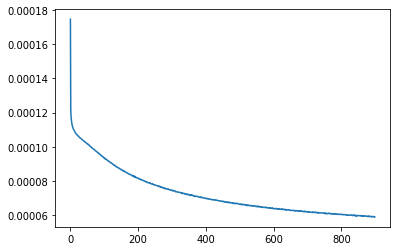

[[-0.31177983 -0.30341607 -0.2585971   0.1279063  -0.34361288 -0.0871487
   0.18254167]]


In [11]:
plt.plot(history.history['loss'])
plt.show()
print(encoder.predict(X_train[0:1,:]))

### Define and Initialize Clustering

In [12]:
#Gaussian miture
from sklearn.mixture import GaussianMixture
encoded = encoder.predict(X_train)
model = GaussianMixture(n_components=2, init_params='random')
y_pred = model.fit_predict(encoded)
print(acc(Y_train, y_pred))

0.6564804256936526


In [13]:
#Clustering
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='Adam', loss='kld')

#Initialize Clusters using K-means
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
y_pred = kmeans.fit_predict(encoder.predict(X_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
print(acc(Y_train, y_pred))

0.9047510452299505


In [14]:
from sklearn.cluster import AgglomerativeClustering
encoded = encoder.predict(X_train)
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
y_pred = cluster.fit_predict(encoded)
print(y_pred[0])
print(Y_train[0])
print(acc(Y_train, y_pred))

0
0.0
0.9688711516533638


In [ ]:
#Parameters iterative process
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(X_train.shape[0])
tol = 0.0001 # tolerance threshold to stop training

### Iterative training process

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(X_train, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if Y_train is not None:
            acc_var = np.round(acc(Y_train, y_pred), 5)
            nmi_var = np.round(nmi(Y_train, y_pred), 5)
            ari_var = np.round(ari(Y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_var, nmi_var, ari_var), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, X_train.shape[0])]
    loss = model.train_on_batch(x=X_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= X_train.shape[0] else 0

model.save_weights(save_dir + name_save_final)